# **The Effects of Automobile Dependency in the United States**
## Contributors: Nicholas Breymaier and Zachary Osborne
Nicholas UID: 117920871 <br>
Zachary UID: 117941609 <br>
<a href='https://github.com/nicholasbreymaier/nicholasbreymaier.github.io'> Source Code </a>

# Introduction
A place, ranging from a neighborhood-scale to nation-scale geographic area, is referred to as <a href='https://www.planetizen.com/definition/automobile-dependency'>automobile dependent</a>, or car dependent, when the only means by which residents are realistically capable of reaching necessities is by driving a personal automobile. By necessities we mean any locations necessary to live a successful life in modern society, such as institutions of education, jobs, and grocery stores. For the purposes of this analysis, the term 'car' or 'automobile' includes standard sedans and station wagons as well as vans and <a href='https://www.ecfr.gov/current/title-40/chapter-I/subchapter-C/part-86/subpart-A/section-86.082-2'>light-duty trucks</a> such as Sport Utility Vehicles (SUVs) and pickup trucks.

This project serves as an analysis of some of the conseqeuences of and alternatives to car dependency in the United States over time for the purpose of raising awareness, but is by no means meant to be a comprehensive review of the subject. For readers who are interested in learning more about the causes of car dependency and how to fix it, we strongly encourage that you do more research on the subject; the "Further Information for Interested Readers" section at the bottom of this webpage may serve as a good place to start.

We will focus primarily on automobile dependency in the United States, but data from other countries will be used for comparative purposes.

## The Importance of Automobile Dependency in the United States
Over <a href='https://www.forbes.com/advisor/car-insurance/car-ownership-statistics'>90%</a> of households in the United States (US) owned at least one car in 2021, with more than <a href='https://www.forbes.com/advisor/car-insurance/car-ownership-statistics/'>59%</a> owning two or more cars owing to the commonness of married couples having seperate jobs. In 2015, over <a href='https://www.bts.gov/content/commute-mode-share-2015'>80%</a> of commutes were taken by car, as were <a href="https://www.epa.gov/greenvehicles/what-if-more-people-bought-groceries-online-instead-driving-store">88%</a> of grocery store trips. As of 2019, over <a href='https://www.bloomberg.com/news/articles/2019-05-07/how-distance-to-school-affects-student-well-being#:~:text=Today%2C%20nearly%2060%20percent%20of,especially%20on%20sleep%20and%20exercise.'>60%</a> of students in primary and secondary education are driven to school. These trends arise because the vast majority of Americans simply have no other choice but to reach their destinations by driving, whether this be due to distance<a href='https://www.nrc.gov/docs/ML1006/ML100621425.pdf'>—the average commute is 15 miles—</a>or to lack of safety, which we address below. In both of these cases, there is a severe lack of safe, long distance alternatives such as <a href='https://www.apta.com/news-publications/public-transportation-facts/'>public transportation</a>. In other words, the United States <a href='https://www.vox.com/22662963/end-driving-obsession-connectivity-zoning-parking'>is car dependent</a>.

This is problematic for <a href ='https://www.strongtowns.org/journal/2015/1/20/the-negative-consequences-of-car-dependency#:~:text=Living%20in%20a%20car%20dependent,)%20and%20indirect%20(taxes.)'>many reasons</a>, the most dire of which are environmental, financial, and mortal—that is, deadly. We are in the middle of the <a href='https://www.who.int/health-topics/climate-change#tab=tab_1'>climate crisis</a> scientists have been warning us of for decades, with a dire and immediate need to halt carbon emissions and find ways to help the ecosphere heal from the damage we've already done. In the midst of this, with transportation being the <a href='https://www.epa.gov/ghgemissions/sources-greenhouse-gas-emissions'>largest contributor</a> to the US's carbon output, the US Department of Transportation is still <a href='https://highways.dot.gov/federal-lands/projects/by-state'>building and widening</a> highways in <a href='https://www.vtpi.org/gentraf.pdf'>futile</a> attempts to relieve incessant conjestion brought about by people having no alternatives to driving, the very construction process of which emits grand quantities of greenhouse gases. This project analyzes the financial and mortal costs of car dependency in the US in more detail below.

## Relevance in the Field of Data Science
Coverage of causes of death by major media institutions in the United States <a href='https://ourworldindata.org/does-the-news-reflect-what-we-die-from'>fails to correlate</a> with what Americans die from, with automobile fatalities and pollution induced illnesses being covered at significantly lower proportions than the proportion of deaths they cause. This is likely due in part to the need for major media companies to "keep up" with the incessant and immediate news which is able to be transmitted via social media, which has lead to companies disproportunately covering eye catching topics like homicide and terrorism to maintain viewership and therefore advertisement revenue. This is part of a larger <a href='https://www.gsb.stanford.edu/insights/media-consolidation-means-less-local-news-more-right-wing-slant'>trend</a> wherein media consolidation into the hands of large corporations causes news stations to prioritize national news as opposed to local news, and often leads to right-wing political slant in coverage. Moreover, major US news corporations increasingly fail to critically examine institutions in relation to societal problems, opting to either not discuss them at all or to atomize important events which are symptoms of larger problems, as may be seen in the coverage of the recent East Palestine <a href='https://en.wikipedia.org/wiki/2023_Ohio_train_derailment'>train derailment</a>. Relying on the media is therefore not an effective way to build public awareness about systemic, societal problems.

Data Science offers a promising alternative medium of news coverage as opposed to major media corporations and news transmitted via social media because it is significantly <a href='https://fivethirtyeight.com/features/what-the-fox-knows/'>less prone to outlier bias</a>. It is capable of analyzing long-term macro-level trends that would take the culmination of thousands of traditional articles to reveal, much less communicate, and may be seen as more democratic than the privately owned media corporations which currently dominate the US news landscape. Anyone with the requisite knowledge, a computer, and internet access can use data science to bring issues to light. This project hopes to demonstrate that data science can be used to generate awareness about important yet overlooked societal issues by using it to do so with car dependency.

# Step 1: Data Collection

In [28]:
# First and foremost, we must import the necessary libraries for data
# collection, tidying, visualization, analysis, modeling, and interpreting.
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import matplotlib.pyplot as plt


Thankfully, the United States Department of Transportation (DOT) National Highway Traffic Safety Administration (NHTSA) keeps a nicely detailed <a href='https://www-fars.nhtsa.dot.gov/Main/index.aspx'> table</a> displayed on its website with data on traffic fatalities from 1994 to 2020. This serves as a good starting point for discussing the death toll of American automobile dependency.

In [29]:
# Use the python requests library to extract the data from the website.
web_extract = requests.get(
    'https://www-fars.nhtsa.dot.gov/Main/index.aspx').text

# Organise and make legible the extracted html using the BeautifulSoup library.
web_extract = bs(web_extract)
web_extract.prettify()

loci = web_extract.find('table')

# Extract the html tables into pandas dataframes. Tables 1–9 were
# stylistic elements in the website.
nhtsa_nat_stats = pd.read_html(str(loci))[10]

Next, we'll delve into more detailed <a href='https://www.bts.gov/topics/national-transportation-statistics'>data</a> courtesy of the DOT's Bureau of Transportation Statistics (BTS). From its national transportation statistics webpage, we'll download the <a href='https://www.bts.gov/content/transit-profile-0'>Transit Profile Spreadsheet</a>, the <a href='https://www.bts.gov/content/highway-profile'>Highway Profile Spreadsheet</a>, and the <a href='https://www.bts.gov/content/automobile-profile'>Automobile Profile Spreadsheet</a>.

In [30]:
# We'll use the requests library to download the spreadsheets directly using
# their respective URLs.

# Use requests to get the spreadsheets.
transitSpreadsheet = requests.get('https://www.bts.gov/sites/bts.dot.gov/files/2023-03/table_transit_profile_032123.xlsx')
highwaySpreadsheet = requests.get('https://www.bts.gov/sites/bts.dot.gov/files/2022-07/table_highway_profile_072322.xlsx')
automobileSpreadsheet = requests.get('https://www.bts.gov/sites/bts.dot.gov/files/2022-04/table_automobile_profile_042522.xlsx')

# Write the spreadsheets directly to local files for easy access.
outfile = open('table_transit_profile_032123.xlsx', 'wb')
outfile.write(transitSpreadsheet.content)

outfile = open('table_highway_profile_072322.xlsx', 'wb')
outfile.write(highwaySpreadsheet.content)

outfile = open('table_automobile_profile_042522.xlsx', 'wb');
outfile.write(automobileSpreadsheet.content);

For all 3 of the BTS profile spreadsheets (transit, highway, and automobile), read into DataFrames, but exclude irrelevant rows of information and irrelevant columns corresponding to years we will not be using. As the information is organized in the spreadsheets, rows are variable names, so we exclude rows corresponding to worthless or irrelevant variables.

In [31]:
# Read the transit spreadsheet information into a pandas DataFrame.

# Irrelevant information grouping headers such as "FINANCIAL" and "PERFORMANCE."
blank_headers = [2, 45, 73, 140]
# Groups of variables which we will not be analyzing such as passenger fare per
# trip.
undesired_data = list(range(27, 45)) + list(range(46, 73)) + \
list(range(74, 92)) + list(range(101, 140)) + list(range(159, 168))

# Read the excel file into a DataFrame, ignoring the rows laid out in the above
# lists. Use the 1st row as column labels since 0th row is empty. Only reads the
# first 165 rows since they are the only rows containing data.
transit_data = pd.read_excel(
    'table_transit_profile_032123.xlsx', 
    header=1, 
    index_col=0, 
    nrows=165,
    skiprows=blank_headers+undesired_data,
    usecols=[0]+list(range(5, 31))
)

# Repeat the aboe process for the highway spreadsheet.

blank_headers = [2, 24, 67, 86]
undesired_data = list(range(25, 67)) + list(range(83, 86)) + [89]

highway_data = pd.read_excel(
    'table_highway_profile_072322.xlsx', 
    header=1, 
    index_col=0, 
    nrows=87,
    skiprows=blank_headers+undesired_data,
    usecols=[0]+list(range(5, 31))
)

# Repeat the aboe process for the automobile spreadsheet.

blank_headers = [2, 14, 26, 72]
undesired_data = [13] + list(range(15, 26)) + list(range(27, 52)) + list(range(56, 72)) + list(range(80, 105))

automobile_data = pd.read_excel(
    'table_automobile_profile_042522.xlsx', 
    header=1, 
    index_col=0, 
    nrows=102,
    skiprows=blank_headers+undesired_data,
    usecols=[0]+list(range(5, 31))
);

#automobile_data.head()
#highway_data.head()
#transit_data.head()

# Step 2: Data Processing


### NHTSA Data
The NHTSA crash fatality data we extracted is far from tidy, so we shall clean and organise it here.\
Firstly, this DataFrame holds features in its rows and observations in its columns. Obervations are, in this case, years. We therefore transpose the dataframe to make the rows observations and the columns features.

In [32]:
# We will want these to be the column labels after transposing the DataFrame.
nhtsa_nat_stats = nhtsa_nat_stats.set_index('Unnamed: 0')

# Transpose the DataFrame.
nhtsa_nat_stats = nhtsa_nat_stats.transpose()

# Rename index column to 'Year' and sort data chronologically.
nhtsa_nat_stats.index.name = 'Year'
nhtsa_nat_stats = nhtsa_nat_stats.sort_index()

nhtsa_nat_stats.columns.name = None

nhtsa_nat_stats.head()

,Motor Vehicle Traffic Crashes,Fatal Crashes,Traffic Crash Fatalities,Vehicle Occupants,Drivers,Passengers,Unknown,Sub Total1,Motorcyclists,Nonmotorists,...,Other National Statistics,Vehicle Miles Traveled (Billions),Resident Population (Thousands),Registered Vehicles (Thousands),Licensed Drivers (Thousands),National Rates: Fatalities,Fatalities per 100 Million Vehicle Miles Traveled,"Fatalities per 100,000 Population","Fatalities per 100,000 Registered Vehicles","Fatalities per 100,000 Licensed Drivers"
Year,,,,,,,,,,,,,,,,,,,,,
1994,NaN,36254.0,NaN,NaN,21596.0,10294.0,108.0,31998.0,2320.0,NaN,...,NaN,2358.0,260327.0,192497.0,175403.0,NaN,1.73,15.64,21.15,23.21
1995,NaN,37241.0,NaN,NaN,22370.0,10576.0,118.0,33064.0,2227.0,NaN,...,NaN,2423.0,262803.0,197065.0,176628.0,NaN,1.73,15.91,21.22,23.68
1996,NaN,37494.0,NaN,NaN,22572.0,10860.0,102.0,33534.0,2161.0,NaN,...,NaN,2484.0,265229.0,201631.0,179539.0,NaN,1.69,15.86,20.86,23.43
1997,NaN,37324.0,NaN,NaN,22730.0,10765.0,114.0,33609.0,2116.0,NaN,...,NaN,2552.0,267784.0,203568.0,182709.0,NaN,1.65,15.69,20.64,22.99
1998,NaN,37107.0,NaN,NaN,22654.0,10327.0,107.0,33088.0,2294.0,NaN,...,NaN,2628.0,270248.0,208076.0,184861.0,NaN,1.58,15.36,19.95,22.45


The original NHTSA data table groups its features into various categories via extra, empty features which essentially function as "headers". This is a very messy way to do this, and furthermore having the categorization within the table is unnecessary. Here, we remove the unnecessary columns and rename the rest for clarity and to preserve information which would otherwise have been lost during the purging of the headers.

In [33]:
# Drop empty header columns.
columns_to_remove = [
    'Motor Vehicle Traffic Crashes', 
    'Traffic Crash Fatalities',
    'Vehicle Occupants', 
    'Nonmotorists',
    'Other National Statistics', 
    'National Rates: Fatalities'
]

nhtsa_nat_stats.drop(columns=columns_to_remove, inplace=True)

# Rename remaining columns for clarity 
nhtsa_nat_stats = nhtsa_nat_stats.rename(
    columns={
        'Drivers' : 'Driver Fatalities',
        'Passengers' : 'Passenger Fatalities',
        'Unknown' : 'Unknown Vehicle Occupant Fatalities',
        'Sub Total1' : 'Total Vehicle Occupant Fatalities',
        'Motorcyclists' : 'Motorcyclist Fatalities',
        'Pedestrians' : 'Pedestrian Fatalities',
        'Pedalcyclists' : 'Pedalcyclist Fatalities',
        'Other/ Unknown' : 'Other/Unknown Nonmotorist Fatalities',
        'Sub Total2' : 'Total Nonmotorist Fatalities',
        'Total*' : 'Total Fatalities'
    }
)

# Drop columns whose data we will not be using.
columns_to_remove = [
    'Fatal Crashes',
    'Passenger Fatalities', # This is already in the ! profile table.
    'Unknown Vehicle Occupant Fatalities',
    'Motorcyclist Fatalities',
    'Pedestrian Fatalities',
    'Pedalcyclist Fatalities',
    'Other/Unknown Nonmotorist Fatalities', # Unknown nature → hard to analyze.
    'Total Fatalities',
    'Vehicle Miles Traveled (Billions)',
    'Fatalities per 100 Million Vehicle Miles Traveled',
    'Fatalities per 100,000 Registered Vehicles',
    'Fatalities per 100,000 Licensed Drivers'
]

nhtsa_nat_stats.drop(columns=columns_to_remove, inplace=True)

# The year 1994 is not included in any of the other data tables, so it will not
# contribute to our analysis.
nhtsa_nat_stats.drop(index='1994', inplace=True)

nhtsa_nat_stats.head();

### Transit Profile Data
The transit profile suffers from the same data organisation perils which plagued the NHTSA dataset. Namely, its rows store varible names and its columns store observaton labels, with these being years.
We therefore transpose the transit profile DataFrame in order to tidy it such that its variable names are its column labels and its observation identifiers (years) are its indices. We then rename columns which were either poorly labeled or had errors in their labels.

In [34]:
# Transpose the datafame as discussed above.
transit_data = transit_data.transpose()
# Set years as indices since the data's observations are different years.
transit_data.index.name = 'Year'

# Rename columns to facilitate readability and fix errors which arose when
# reading superscript characters from original Excel sheet into pandas.
transit_data = transit_data.rename(
    columns={
        'Light raila' : 'Light rail',
        'Light raila ' : 'Light rail',
        'Ferryboatb' : 'Ferryboat',
        'Otherc' : 'Other',
        'Operating assistanced, total' : 'Operating assistance, total',
        'Commuter railf' : 'Commuter rail',
        'Injured persons, all modesk' : 'Injured persons, all modes'
    }
)

Lastly, we remove the columns we will not be working with to minimise clutter. These are mostly sub-categories of data which we intend to analyze on the macro-level.

In [35]:
# Remove worthless and undesired columns.
columns_to_remove = [
    'Motor bus',
    'Heavy rail',
    'Light rail',
    'Trolley bus',
    'Demand responsive',
    'Ferryboat',
    'Commuter rail',
    'Other',
    'Other operating revenue',
    'Operating assistance, total',
    'State and local',
    'Federal'
]
transit_data.drop(columns=columns_to_remove, inplace=True)

"Passenger operating revenues, total (millions of dollars)" functions as a header for "Operating revenues, total" and "Passenger fares, total" so we have to rename them the sub-categories to reflect the information which would otherwise be lost upon dropping the header column.

In [36]:
# Rename relevant subcategory column labels.
transit_data.rename(
    columns={
        'Operating revenues, total' : 'Operating revenues, total (millions of dollars)',
        'Passenger fares, total' : 'Passenger fares, total (millions of dollars)'
    },
    inplace=True
)

# Drop empty header column.
transit_data.drop(columns='Passenger operating revenues, total (millions of dollars)', inplace=True)

# Behold the fruits of our labour!
transit_data.head()

,"Operating revenues, total (millions of dollars)","Passenger fares, total (millions of dollars)","Operating expenses, total (millions of dollars)","Passenger-miles, total (millions)","Fatalities, all modes","Injured persons, all modes"
Year,,,,,,
1995,7740.385752,6800.9,17848.7,39808,269,57237
1996,8347.481046,7416.3,18340.7,41378,264,55860
1997,8638.638762,7545.7,18936.1,42375,285,56036
1998,9029.061773,7969.6,19738.5,44128,252,56327
1999,9375.627639,8282.4,20512.1,45857,261,55663


### Highway Profile Data
We will now tidy the highway profile data in precisely the same way we tidied the transit profile data since they suffer from the same problems owning to their identical structural layouts.

In [37]:
highway_data = highway_data.transpose()
highway_data.index.name = 'Year'

highway_data.head()

,"Government receipts, total (millions of dollars)","Federal, total",Highway trust funda,Other,"State and local, total",State and D.C.,Local,"Government expenditures, total (millions of dollars)","Federal, total",Highway trust funda,...,Local,"Urban mileage, total",Interstate,Other freeways and expressways,Other principal arterial,Minor arterial,Collectorj,Local,Fatalities,Injured persons
Year,,,,,,,,,,,,,,,,,,,,,
1995,96347,19851,18835,1016,76496,50064,26432,93478,1402,1092,...,105164,1489534,341528,151560,370338,293272,126929,205907,41817,3437000
1996,102771,23196,22036,1160,79575,52808,26767,98082,1598,1384,...,107752,1523886,351579,157502,377776,299345,129310,208374,42065,3440000
1997,107421,21648,20500,1148,85773,58087,27686,101953,1315,1103,...,112865,1552956,361433,159572,385123,301932,130146,214750,42013,3321000
1998,111581,24509,23396,1113,87072,58806,28266,107975,1375,1170,...,119656,1595620,374622,165632,388071,309293,131905,226097,41501,3199000
1999,121650,26008,25085,923,95642,63274,32368,116010.9,1427.9,1249,...,124684,1627618,383259,171515,392688,313950,131603,234603,41717,3250000


In [38]:
highway_data = highway_data.rename(
    columns={
        'Highway trust funda' : 'Highway trust fund',
        'Otherb' : 'Other',
        'State highway user tax revenuesc, total (millions of dollars)' : 'State highway user tax revenues, total (millions of dollars)',
        'Other motor fuel receiptsd' : 'Other motor fuel receipts',
        'Other motor vehicle feese' : 'Other motor vehicle fees',
        'Motor carrier taxesf' : 'Motor carrier taxes',
        'Miscellaneous feesg' : 'Miscellaneous fees',
        'Vehicle-miles of travel by functional system (millions), total n' : 'Vehicle-miles of travel by functional system (millions), total',
        'Collectorj' : 'Collector'
    }
)

highway_data.head()

,"Government receipts, total (millions of dollars)","Federal, total",Highway trust fund,Other,"State and local, total",State and D.C.,Local,"Government expenditures, total (millions of dollars)","Federal, total",Highway trust fund,...,Local,"Urban mileage, total",Interstate,Other freeways and expressways,Other principal arterial,Minor arterial,Collector,Local,Fatalities,Injured persons
Year,,,,,,,,,,,,,,,,,,,,,
1995,96347,19851,18835,1016,76496,50064,26432,93478,1402,1092,...,105164,1489534,341528,151560,370338,293272,126929,205907,41817,3437000
1996,102771,23196,22036,1160,79575,52808,26767,98082,1598,1384,...,107752,1523886,351579,157502,377776,299345,129310,208374,42065,3440000
1997,107421,21648,20500,1148,85773,58087,27686,101953,1315,1103,...,112865,1552956,361433,159572,385123,301932,130146,214750,42013,3321000
1998,111581,24509,23396,1113,87072,58806,28266,107975,1375,1170,...,119656,1595620,374622,165632,388071,309293,131905,226097,41501,3199000
1999,121650,26008,25085,923,95642,63274,32368,116010.9,1427.9,1249,...,124684,1627618,383259,171515,392688,313950,131603,234603,41717,3250000


Removing undesired non-headers

In [39]:
columns_to_remove=[
    'Federal, total',
    'Highway trust fund',
    'Other',
    'State and local, total',
    'State and D.C.',
    'Local',
    'Motor fuel tax',
    'Other motor fuel receipts',
    'Motor vehicle registration fees ',
    'Other motor vehicle fees',
    'Motor carrier taxes',
    'Miscellaneous fees',
    'Rural mileage, total',
    'Interstate',
    'Interstate ',
    'Other freeways and expressways',
    'Other principal arterial',
    'Minor arterial',
    'Collector',
    'Urban mileage, total'
]

highway_data.drop(columns=columns_to_remove, inplace=True)

highway_data.head()

,"Government receipts, total (millions of dollars)","Government expenditures, total (millions of dollars)","State highway user tax revenues, total (millions of dollars)","Vehicle-miles of travel by functional system (millions), total",Fatalities,Injured persons
Year,,,,,,
1995,96347,93478,47423.981,2422823,41817,3437000
1996,102771,98082,49755.834,2484080,42065,3440000
1997,107421,101953,51381,2552233,42013,3321000
1998,111581,107975,54507,2628148,41501,3199000
1999,121650,116010.9,56269,2690241,41717,3250000


### Automobile Profile Data

In [40]:
automobile_data = automobile_data.transpose()
automobile_data.index.name = 'Year'

automobile_data.head()

,"Personal auto expenditures, totala (millions of dollars)",New cars,Used cars,Parts and accessories,Gasoline and oil,Maintainence and repair,Other services,Insurance premiums less claims paid,Auto registration fees,Driver's license fees,...,"Light duty vehicle, short wheel basec,j","Light duty vehicle, long wheel basee,j","Motorcyclef,i",Number of occupants and nonoccupant fatalities,Passenger car,Light truck,Motorcycle,Bicycled,Pedestriand,Other/Unknown
Year,,,,,,,,,,,,,,,,,,,,,
1995,541051,147451,72892,35366,120410,86908,35662,34496,7043,823,...,2286887,1256146,10777,41817,22423,9568,2227,833,5584,3801
1996,582650.0,152971.0,82868.0,37647.0,130494.0,90755.0,42622.0,36702.0,7698.0,893.0,...,2335478.267119,1297337.201159,10904.486162,42065.0,22505.0,9932.0,2161.0,765.0,5449.0,3867.0
1997,619133,162209,91741,39133,134428,93857,50930,37807,8163,865,...,2389065,1352675,11089,42013,22199,10249,2116,814,5321,3850
1998,642952.0,179374.0,101354.0,39477.0,120787.0,99567.0,52464.0,40382.0,8630.0,917.0,...,2463828.420042,1380557.239794,11311.197996,41501.0,21194.0,10705.0,2294.0,760.0,5228.0,4023.0
1999,701297.0,200058.0,109602.0,41070.0,134190.0,105852.0,57762.0,43234.0,8625.0,904.0,...,2495140.302624,1432782.379408,11642.29501,41717.0,20862.0,11265.0,2483.0,754.0,4939.0,4344.0


In [41]:
automobile_data = automobile_data.rename(
    columns={
        'Personal auto expenditures, totala (millions of dollars)' : 'Personal auto expenditures, total (millions of dollars)',
        'Light duty vehicle, short wheel basec,j' : 'Light duty vehicle, short wheel base',
        'Light duty vehicle, long wheel basee,j' : 'Light duty vehicle, long wheel base',
        'Motorcyclef,i' : 'Motorcycle',
        'Bicycled' : 'Bicycle',
        'Pedestriand' : 'Pedestrian'
    }
)

automobile_data.head()

,"Personal auto expenditures, total (millions of dollars)",New cars,Used cars,Parts and accessories,Gasoline and oil,Maintainence and repair,Other services,Insurance premiums less claims paid,Auto registration fees,Driver's license fees,...,"Light duty vehicle, short wheel base","Light duty vehicle, long wheel base",Motorcycle,Number of occupants and nonoccupant fatalities,Passenger car,Light truck,Motorcycle,Bicycle,Pedestrian,Other/Unknown
Year,,,,,,,,,,,,,,,,,,,,,
1995,541051,147451,72892,35366,120410,86908,35662,34496,7043,823,...,2286887,1256146,10777,41817,22423,9568,2227,833,5584,3801
1996,582650.0,152971.0,82868.0,37647.0,130494.0,90755.0,42622.0,36702.0,7698.0,893.0,...,2335478.267119,1297337.201159,10904.486162,42065.0,22505.0,9932.0,2161.0,765.0,5449.0,3867.0
1997,619133,162209,91741,39133,134428,93857,50930,37807,8163,865,...,2389065,1352675,11089,42013,22199,10249,2116,814,5321,3850
1998,642952.0,179374.0,101354.0,39477.0,120787.0,99567.0,52464.0,40382.0,8630.0,917.0,...,2463828.420042,1380557.239794,11311.197996,41501.0,21194.0,10705.0,2294.0,760.0,5228.0,4023.0
1999,701297.0,200058.0,109602.0,41070.0,134190.0,105852.0,57762.0,43234.0,8625.0,904.0,...,2495140.302624,1432782.379408,11642.29501,41717.0,20862.0,11265.0,2483.0,754.0,4939.0,4344.0


In [42]:
columns_to_remove = [
    'New cars',
    'Used cars',
    'Parts and accessories',
    'Gasoline and oil',
    'Maintainence and repair',
    'Other services',
    'Insurance premiums less claims paid',
    'Auto registration fees',
    'Driver\'s license fees',
    'Light duty vehicle, short wheel base',
    'Light duty vehicle, long wheel base',
    'Motorcycle',
    'Passenger car',
    'Light truck',
    'Bicycle',
    'Pedestrian',
    'Other/Unknown'
]

automobile_data.drop(columns=columns_to_remove, inplace=True)

automobile_data.head()

,"Personal auto expenditures, total (millions of dollars)","Passenger-miles, total (millions)",Number of occupants and nonoccupant fatalities
Year,,,
1995,541051,3553810,41817
1996,582650.0,3643719.95444,42065.0
1997,619133,3752829,42013
1998,642952.0,3855696.857832,41501.0
1999,701297.0,3939564.977043,41717.0


### Combining the data

Confirming index types match

In [43]:
print(f'Transit index type: {transit_data.index.dtype}')
print(f'Highway index type: {highway_data.index.dtype}')
print(f'Automobile index type: {automobile_data.index.dtype}')
print(f'NHTSA index type: {nhtsa_nat_stats.index.dtype}')

Transit index type: int64
Highway index type: int64
Automobile index type: int64
NHTSA index type: object


In [44]:
nhtsa_nat_stats.index = nhtsa_nat_stats.index.astype(transit_data.index.dtype)

nhtsa_nat_stats.index.dtype

dtype('int64')

In [45]:
full_df = pd.concat(
    {
        'NHTSA Stats' : nhtsa_nat_stats, 
        'Transit Profile' : transit_data,
        'Highway Profile' : highway_data,
        'Automobile Profile' : automobile_data
    },
    axis=1
)

full_df.head()

NHTSA Stats                                    \
     Driver Fatalities Total Vehicle Occupant Fatalities   
Year                                                       
1995           22370.0                           33064.0   
1996           22572.0                           33534.0   
1997           22730.0                           33609.0   
1998           22654.0                           33088.0   
1999           22971.0                           33392.0   

                                                                   \
     Total Nonmotorist Fatalities Resident Population (Thousands)   
Year                                                                
1995                       6526.0                        262803.0   
1996                       6368.0                        265229.0   
1997                       6288.0                        267784.0   
1998                       6119.0                        270248.0   
1999                       5842.0                        272691.0   

                                                                   \
     Registered Vehicles (Thousands) Licensed Drivers (Thousands)   
Year                                                                
1995                        197065.0                     176628.0   
1996                        201631.0                     179539.0   
1997                        203568.0                     182709.0   
1998                        208076.0                     184861.0   
1999                        212685.0                     187170.0   

                                        \
     Fatalities per 100,000 Population   
Year                                     
1995                             15.91   
1996                             15.86   
1997                             15.69   
1998                             15.36   
1999                             15.30   

                                     Transit Profile  \
     Operating revenues, total (millions of dollars)   
Year                                                   
1995                                     7740.385752   
1996                                     8347.481046   
1997                                     8638.638762   
1998                                     9029.061773   
1999                                     9375.627639   

                                                   \
     Passenger fares, total (millions of dollars)   
Year                                                
1995                                       6800.9   
1996                                       7416.3   
1997                                       7545.7   
1998                                       7969.6   
1999                                       8282.4   

                                                      ...  \
     Operating expenses, total (millions of dollars)  ...   
Year                                                  ...   
1995                                         17848.7  ...   
1996                                         18340.7  ...   
1997                                         18936.1  ...   
1998                                         19738.5  ...   
1999                                         20512.1  ...   

                                 \
     Injured persons, all modes   
Year                              
1995                      57237   
1996                      55860   
1997                      56036   
1998                      56327   
1999                      55663   

                                      Highway Profile  \
     Government receipts, total (millions of dollars)   
Year                                                    
1995                                            96347   
1996                                           102771   
1997                                           107421   
1998                                           111581   
1999                                        

In [46]:
full_df.rename(
    columns={
        'Total Vehicle Occupant Fatalities' : 'Vehicle Occupant Fatalities',
        'Total Nonmotorist Fatalities' : 'Nonmotorist Fatalities',
        'Resident Population (Thousands)' : 'Resident Population (Thousands)',
        'Registered Vehicles (Thousands)' : 'Registered Vehicles (Thousands)',
        'Licensed Drivers (Thousands)' : 'Licensed Drivers (Thousands)',
        'Operating revenues, total (millions of dollars)' : 'Operating Revenues (Millions USD)',
        'Passenger fares, total (millions of dollars)' : 'Passenger Fares (Millions USD)',
        'Operating expenses, total (millions of dollars)' : 'Operating Expenses (Millions USD)',
        'Passenger-miles, total (millions)' : 'Passenger-Miles (Millions)',
        'Fatalities, all modes' : 'Fatalities',
        'Injured persons, all modes' : 'Injured Persons',
        'Government receipts, total (millions of dollars)' : 'Gov Receipts (Millions USD)',
        'Government expenditures, total (millions of dollars)' : 'Gov Expenditures (Millions USD)',
        'State highway user tax revenues, total (millions of dollars)' : 'State Highway User Tax Revenues (Millions USD)',
        'Vehicle-miles of travel by functional system (millions), total' : 'Vehicle-Miles (Millions)',
        'Injured persons' : 'Injured Persons',
        'Personal auto expenditures, total (millions of dollars)' : 'Personal Auto Expenditures (Millions USD)',
        'Number of occupants and nonoccupant fatalities' : 'Fatalities'
    },
    inplace=True
)

full_df.columns.values

array([('NHTSA Stats', 'Driver Fatalities'),
       ('NHTSA Stats', 'Vehicle Occupant Fatalities'),
       ('NHTSA Stats', 'Nonmotorist Fatalities'),
       ('NHTSA Stats', 'Resident Population (Thousands)'),
       ('NHTSA Stats', 'Registered Vehicles (Thousands)'),
       ('NHTSA Stats', 'Licensed Drivers (Thousands)'),
       ('NHTSA Stats', 'Fatalities per 100,000 Population'),
       ('Transit Profile', 'Operating Revenues (Millions USD)'),
       ('Transit Profile', 'Passenger Fares (Millions USD)'),
       ('Transit Profile', 'Operating Expenses (Millions USD)'),
       ('Transit Profile', 'Passenger-Miles (Millions)'),
       ('Transit Profile', 'Fatalities'),
       ('Transit Profile', 'Injured Persons'),
       ('Highway Profile', 'Gov Receipts (Millions USD)'),
       ('Highway Profile', 'Gov Expenditures (Millions USD)'),
       ('Highway Profile', 'State Highway User Tax Revenues (Millions USD)'),
       ('Highway Profile', 'Vehicle-Miles (Millions)'),
       ('Highway Pro

##### Missing Data

In [47]:
full_df[[('Highway Profile', 'Gov Receipts (Millions USD)'), ('Highway Profile', 'Gov Expenditures (Millions USD)')]].tail(10)

Highway Profile                                
     Gov Receipts (Millions USD) Gov Expenditures (Millions USD)
Year                                                            
2011                           U                               U
2012               216560.977277                   221318.653232
2013                           U                               U
2014               252642.095829                   238428.647249
2015                  241062.991                      235195.187
2016               267940.664818                   219000.917244
2017                           U                               U
2018               237832.857709                      244498.422
2019               260821.828502                      258054.829
2020               257016.393743                      261479.993

In [48]:
full_df.replace('U', float('NaN'), inplace=True)

full_df[[('Highway Profile', 'Gov Receipts (Millions USD)'), ('Highway Profile', 'Gov Expenditures (Millions USD)')]].tail(10)

Highway Profile                                
     Gov Receipts (Millions USD) Gov Expenditures (Millions USD)
Year                                                            
2011                         NaN                             NaN
2012               216560.977277                   221318.653232
2013                         NaN                             NaN
2014               252642.095829                   238428.647249
2015               241062.991000                   235195.187000
2016               267940.664818                   219000.917244
2017                         NaN                             NaN
2018               237832.857709                   244498.422000
2019               260821.828502                   258054.829000
2020               257016.393743                   261479.993000

##### Feature value types

In [49]:
full_df = full_df.apply(pd.to_numeric)

##### Final datatable

In [50]:
full_df

NHTSA Stats                                                     \
     Driver Fatalities Vehicle Occupant Fatalities Nonmotorist Fatalities   
Year                                                                        
1995           22370.0                     33064.0                 6526.0   
1996           22572.0                     33534.0                 6368.0   
1997           22730.0                     33609.0                 6288.0   
1998           22654.0                     33088.0                 6119.0   
1999           22971.0                     33392.0                 5842.0   
2000           22914.0                     33451.0                 5597.0   
2001           22914.0                     33243.0                 5756.0   
2002           23625.0                     34105.0                 5630.0   
2003           23352.0                     33627.0                 5543.0   
2004           23158.0                     33276.0                 5532.0   
2005           23237.0                     33070.0                 5864.0   
2006           22831.0                     32119.0                 5752.0   
2007           21717.0                     30527.0                 5558.0   
2008           19279.0                     26791.0                 5320.0   
2009           17670.0                     24526.0                 4888.0   
2010           16864.0                     23371.0                 5110.0   
2011           16474.0                     22510.0                 5339.0   
2012           16838.0                     23017.0                 5779.0   
2013           16520.0                     22483.0                 5718.0   
2014           16470.0                     22307.0                 5843.0   
2015           17615.0                     23899.0                 6556.0   
2016           18717.0                     25276.0                 7193.0   
2017           18819.0                     25130.0                 7117.0   
2018           18321.0                     24332.0                 7465.0   
2019           17984.0                     23891.0                 7420.0   
2020           19519.0                     25536.0                 7709.0   

                                                                      \
     Resident Population (Thousands) Registered Vehicles (Thousands)   
Year                                                                   
1995                        262803.0                        197065.0   
1996                        265229.0                        201631.0   
1997                        267784.0                        203568.0   
1998                        270248.0                        208076.0   
1999                        272691.0                        212685.0   
2000                        282162.0                        217028.0   
2001                        284969.0                        221230.0   
2002                        287625.0                        225685.0   
2003                        290108.0                        230633.0   
2004                        292805.0                        237949.0   
2005                        295517.0                        245628.0   
2006                        298380.0                        251415.0   
2007                        301231.0                        257472.0   
2008                        304094.0                        259360.0   
2009                        306772.0                        258958.0   
2010                        309327.0                        257312.0   
2011                        311583.0                        265043.0   
2012                        313878.0                        265647.0   
2013                        316060.0                        269294.0   
2014                        318386.0                        274805.0   
2015                        320739.0                        281312.0   
2016                        323072.0             

Keeping the below as an example in case we need to do something similar later, remove before submitting

essentially converts header column structure to multi-index structure

In [51]:
# # preserving information which would otherwise be lost due to removal of the sub-header formatting of
# # the first 15 columns
# trans_p = trans_p.rename(
#     columns={
#         'Operating revenues, total' : 'Total operating revenues',
#         'Passenger fares, total' : 'Total passenger fares',
#         'Other operating revenue' : 'Non-fare operating revenue',
#         'Operating assistance, total' : 'Total operating assistance',
#         'State and local' : 'State and local operating assistance',
#         'Federal' : 'Federal operating assistance'
#     }
# )
# for i in range(3, 11):
#     trans_p.columns.values[i] += ' passenger fares'

# # Renaming columns to remove information which will soon be contained in the top-level columns
# trans_p = trans_p.rename(
#     columns={
#         'Passenger operating revenues, total (millions of dollars)' : 'Total',
#         'Operating expenses, total (millions of dollars)' : 'Total',
#         'Average passenger revenue per passenger-mile, all modes (dollars)' : 'All modes',
#         'Number of vehicles, total' : 'Total',
#         'Vehicle-miles, total (millions)' : 'Total',
#         'Passenger-miles, total (millions)' : 'Total',
#         'Energy consumption, diesel, total (million gallons)' : 'Total',
#         'Energy consumption, other, total (million gallons)' : 'Total',
#         'Energy consumption, electric power, total (million kWh)' : 'Total',
#         'Fatalities, all modes' : 'All modes',
#         'Injured persons, all modes' : 'All modes',
#         'Incidents, all modes' : 'All modes'
#     }
# )

# headers = (
#     ['Passenger Operating Revenues (Millions USD)'] * 15
#     + ['Operating Expenses (Millions USD)'] * 9
#     + ['Avg Passenger Revenue Per Passenger Mile (USD)'] * 9
#     + ['Number of Vehicles'] * 9
#     + ['Vehicle Miles (Millions)'] * 9
#     + ['Passenger Miles (Millions)'] * 9
#     + ['Diesel Energy Consumption (Million Gallons)'] * 9
#     + ['Other Energy Consumption (Million Gallons)'] * 3
#     + ['Electric Energy Consumption (Million kWh)'] * 9
#     + ['Fatalities'] * 9
#     + ['Injured Persons'] * 9
#     + ['Incidents'] * 9
# )

# trans_p.columns = pd.MultiIndex.from_tuples(list(zip(headers, trans_p.columns)))

# trans_p.head()

# Step 3: Exploratory Analysis & Data Visualization

As a part of our exploration and analysis of the data, we will want to visualize it through graphs. To aid in this, we have defined a function for plotting columns of a dataframe against the indices/other columns of the same dataframe below. Note that if one wants to make additional modifications to the plot beyond those of this function, they need only make such modifications prior to calling it. 

In [52]:
def plot_cols(df, y_cols, title, xlabel=None, ylabel=None, x_col=None):
    """
    Plots the specified columns y_cols of the dataframe df against either the indices of
    the dataframe or optionally a specified column x_col. All plotted lines will be on
    the same graph, with a legend to differentiate them

    If not specified, xlabel will default to x_col/index name and ylabel will default to y_cols[0]
    """

    # y_cols is expected to be a type list, so if the user passes a single column name we
    # want to make sure to convert it to a list of a single item
    y_cols = [y_cols] if type(y_cols) == str else y_cols
    # as explained above, y columns will be graphed against the dataframe indices if no column
    # is specifed for the x-axis
    x = df.index if x_col == None else df[x_col]
    # setting to defaults, as defined above, if necessary
    xlabel = df.columns.name if xlabel == None else xlabel
    ylabel = y_cols[0] if ylabel == None else ylabel

    # plots a line for each column
    for y_col in y_cols:
        plt.plot(x, df[y_col], label=y_col)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

KeyError: 'Fatal Crashes'

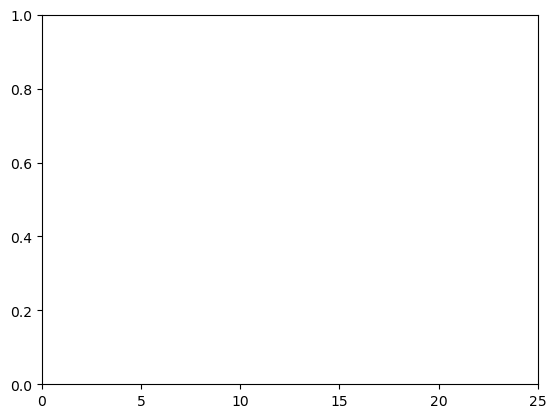

In [53]:
plt.xticks(range(0, len(nhtsa_nat_stats.index), 5))
plot_cols(nhtsa_nat_stats, 'Fatal Crashes', 'Yearly Fatal Motor Vehicle Crashes in the U.S.')

# Step 4: Modeling and Further Analysis with Machine Learning and Statistics

# Step 5: Data Interpretation and Insight

# Further Information for Interested Persons

There are many advocates and advocacy groups, from local international, fighting to spread awareness about this issue and push for solutions to be implemented. Here a few are listed, as well as some sources of more information about car dependency:
> * <a href='https://en.wikipedia.org/wiki/Car_dependency'>Wikipedia</a> is always a good starting point.
> * <a href='https://www.planetizen.com/definition/automobile-dependency'>Planetizen</a> and <a href='https://www.vtpi.org/tdm/tdm100.htm'>Victoria Transport Poliy Institute</a> both have very good articles defining and detailing some common aspects of car dependency.
> * <a href='https://www.youtube.com/@NotJustBikes/featured'>Not Just Bikes</a>, courtesy of Jason Slaughter, became most popular 'urban planning' channel on YouTube as of 2022. Not Just Bikes explores Dutch urban design and transportation engineering with a focus on comparing it to American and Canadian development. Car dependency is a central topic throughout these videos.
> * <a href='strongtowns.org'>Strong Towns</a> is an American advocacy organisation focused on local governance, city finances, and urban development. Its founder, Charles Marohn, served as a professional traffic engineer, and advocates for reduced car dependency in tandem with zoning reform and road design reform in the US.

# Bibliography
(3) https://nepis.epa.gov/Exe/ZyPDF.cgi?Dockey=P1013L1O.pdf 3 <br>